Build a simple CNN Auto-Encoder to reconstruct image. Auto-Encoder require good amount of training for correct output. So smaller image size is better to save training time. 

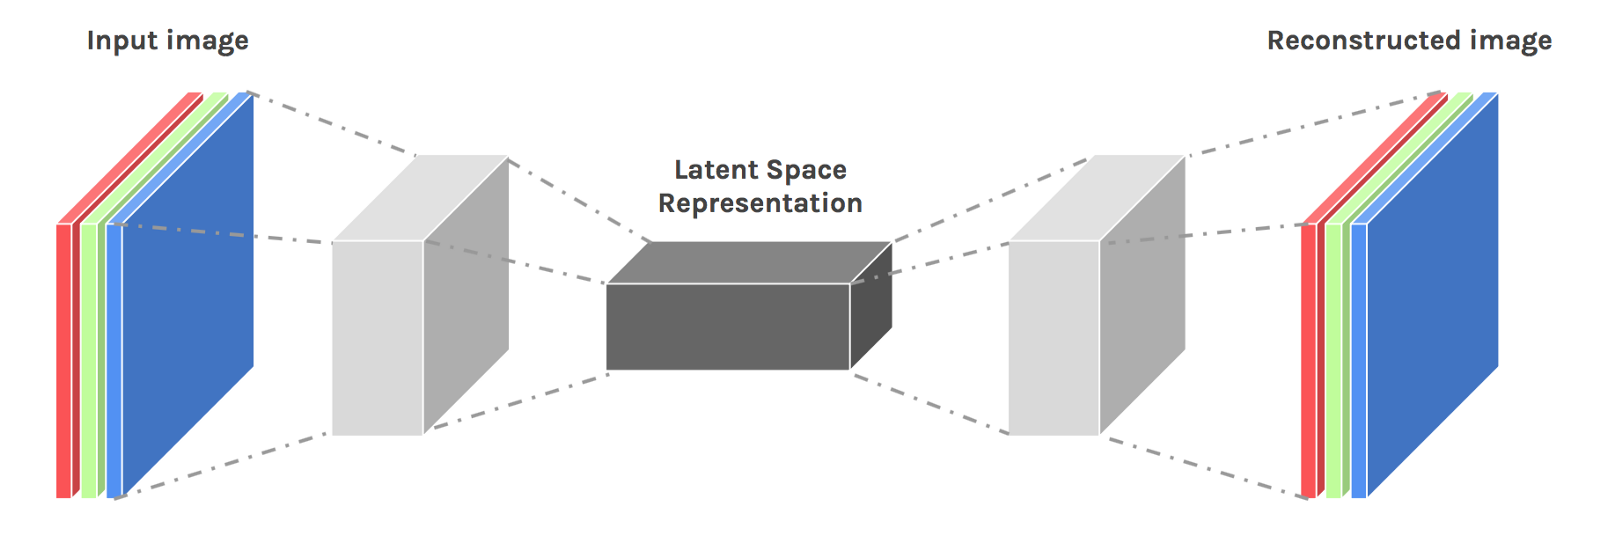

Here 
1. Input image is a normal image.
2. The latent space is a representation of this image in a smaller dimension. 
3. The Reconstructed image is a image similar to input image. </br>
Task here is to construct an image like the original input image using the learned latent space. More details [here](https://blog.keras.io/building-autoencoders-in-keras.html)

In [10]:
import torch, cv2, os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchvision.datasets import QMNIST
from torch.utils.data import DataLoader

## Load MNIST

In [31]:
BATCH_SIZE = 1024

img_transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = QMNIST('./data/', transform=img_transform, download=True, train=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

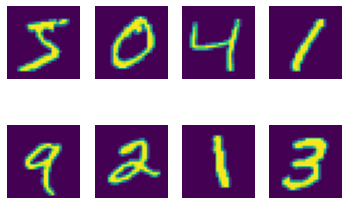

In [6]:
ROWS, COLS = 2, 4
samples = []

for image, _ in dataset:
  samples.append(image)
  if len(samples) == ROWS*COLS:
    break

f, axs = plt.subplots(ROWS,COLS)
a= 0

for i in range(ROWS):
  for j in range(COLS):
    im = samples[a].reshape(28, 28)
    axs[i,j].imshow(im)
    axs[i,j].axis('off')
    a+=1

In [7]:
dataset[0][0].shape

torch.Size([1, 28, 28])

build encoder and decoder to input single channel image and output single channel image.

In [ ]:
# test, check, build auto encoder
x = nn.Conv2d(1, 16, 3, stride=2, padding=1)(dataset[0][0].reshape(1, 1, 28, 28))
x = nn.ReLU()(x)
x = nn.MaxPool2d(kernel_size=2)(x)
x = nn.Conv2d(16, 8, 3, stride=2, padding=1)(x)
x = nn.ReLU()(x)
x = nn.MaxPool2d(kernel_size=2)(x) # (1, 8, 2, 2) encoder output i.e latent space

x = nn.ConvTranspose2d(8, 16, 4, stride=2)(x) # input latent space to decoder
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(16, 8, 4, stride=2)(x)
x = nn.ReLU()(x)
nn.ConvTranspose2d(8, 1, 2, stride=2)(x).shape # (decoder output) make sure it is same size as input image

torch.Size([1, 1, 28, 28])

## Build Auto-Encoder

In [8]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 16, 3, stride=2, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2),
                                      nn.Conv2d(16, 8, 3, stride=2, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2)
                                      )
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(8, 16, 4, stride=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 8, 4, stride=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(8, 1, 2, stride=2),
                                     nn.Tanh() # tanh is faster than sigmoid, we can clip [0,1] later
                                      )

    def forward(self, x):
      x = self.encoder(x)
      x1 = self.decoder(x)
      return x1     

## AutoEncoder to Reconstruct image

In [11]:
%%time

LR = 0.001
epochs = 30
print_epoch = 10
best_loss = 0.50
model_save_path1 = "/content/autoencoder1.bin"
model = AutoEncoder().cuda(0) 
criterion = nn.MSELoss() # simple MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)

if os.path.isfile(model_save_path1):
  save_m = torch.load(model_save_path1)
  model.load_state_dict(save_m['model_state_dict'])
  optimizer.load_state_dict(save_m['optimizer_state'])
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, last_epoch=save_m['prev_epoch'], eta_min=1e-7)
  scheduler.load_state_dict(save_m['scheduler_state'])
  print('loaded')

train_step = len(dataset)/BATCH_SIZE
print("--Training Started--")
for epoch in range(1,epochs+1):
  running_loss = 0.0
  for images, _ in dataloader:
    optimizer.zero_grad()
    images = images.cuda(0)
    reconstructed_images = model(images)
    loss = criterion(images, reconstructed_images) 
    running_loss+=loss.detach()       
    loss.backward()
    optimizer.step() 
  train_loss = running_loss/train_step
  scheduler.step()
  if train_loss < best_loss:
    best_loss = train_loss
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'prev_epoch': epoch
            }, model_save_path1)
  if epoch % print_epoch == 0:
    print("Epoch:", epoch)
    print("Train Loss:", train_loss.item())
print('')    
print("--Training Complete--")    
print("Best loss:", best_loss.item())

--Training Started--
Epoch: 10
Train Loss: 0.028503164649009705
Epoch: 20
Train Loss: 0.021867932751774788
Epoch: 30
Train Loss: 0.021042801439762115

--Training Complete--
Best loss: 0.021042801439762115
CPU times: user 3min 11s, sys: 731 ms, total: 3min 12s
Wall time: 3min 12s


## Results

Original images and reconstructed images


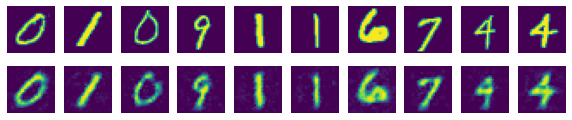

In [35]:
model.load_state_dict(torch.load(model_save_path1)["model_state_dict"])
reconstructed_images = model(images)
ROWS, COLS = 2, 10
recontructed_samples = []

for image in reconstructed_images:
  image = image.clamp(0,1) # instead of sigmoid clip tanh's output to [0,1]
  recontructed_samples.append(image.cpu().detach().numpy())
  if len(recontructed_samples) == ROWS*COLS:
    break

f, axs = plt.subplots(ROWS,COLS, figsize=(10,2))
a,b = 0,0

for i in range(ROWS):
  for j in range(COLS):
    if i == 1:
      im = recontructed_samples[a].reshape(28,28) 
      a+=1
    else:
      im = images[b].cpu().detach().numpy().reshape(28,28) 
      b+=1
    axs[i,j].imshow(im)
    axs[i,j].axis('off')
print('Original images and reconstructed images')    

## AutoEncoder to Denoise image

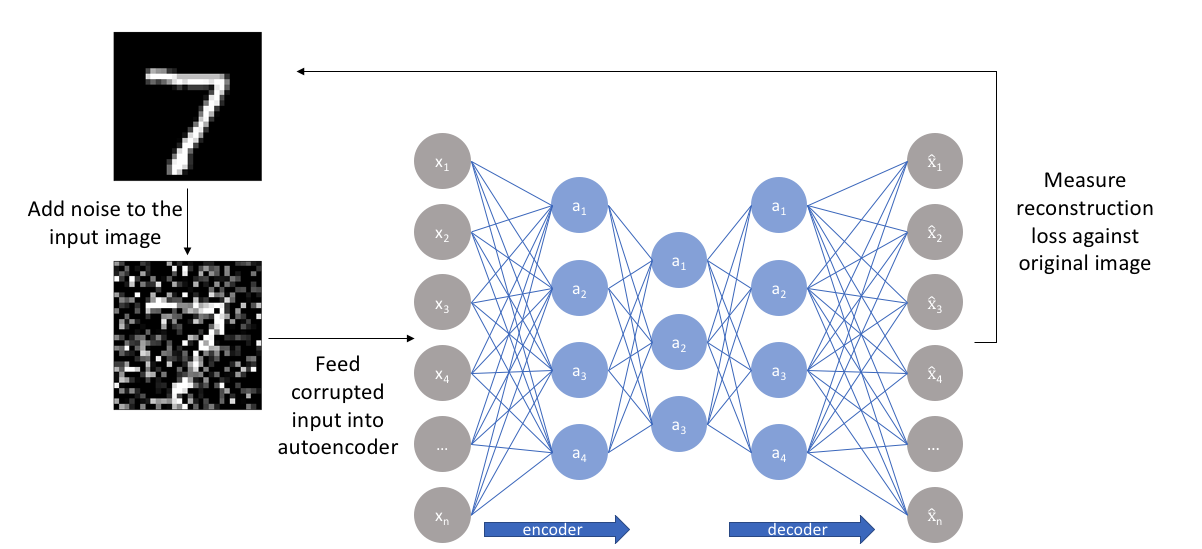

Task here is to learn a autoencoder to remove noise from input image.</br>
So Here 
1. Input image is a noisy image.
2. The latent space is a representation of this image in a smaller dimension. 
3. The Reconstructed image is a image similar to the original image. 


In [18]:
def add_noise(images,noise_factor = 0.2):
  # add noise to images/image 
  images = images + (noise_factor*np.random.normal(0, 1, size=images.shape)) # additive noise
  images = images.type(torch.float32) 
  images = np.clip(images, 0., 1.)
  return images

In [19]:
%%time

LR = 0.001
epochs = 50 
print_epoch = 10
best_loss = 0.50
model_save_path2 = "/content/autoencoder2.bin"
model = AutoEncoder().cuda(0) 
criterion = nn.MSELoss() # simple MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)

if os.path.isfile(model_save_path2):
  save_m = torch.load(model_save_path2)
  model.load_state_dict(save_m['model_state_dict'])
  optimizer.load_state_dict(save_m['optimizer_state'])
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, last_epoch=save_m['prev_epoch'], eta_min=1e-7)
  scheduler.load_state_dict(save_m['scheduler_state'])

train_step = len(dataset)/BATCH_SIZE
print("--Training--")
for epoch in range(1,epochs+1):
  running_loss = 0.0
  for images, _ in dataloader:
    optimizer.zero_grad()
    noisy_images = add_noise(images)
    images, noisy_images = images.cuda(0), noisy_images.cuda(0)
    reconstructed_images = model(noisy_images) # input noisy images
    loss = criterion(images, reconstructed_images) # check mse between clean and noisy images
    running_loss+=loss.detach()       
    loss.backward()
    optimizer.step() 
  train_loss = running_loss/train_step
  scheduler.step()
  if train_loss < best_loss: # save best model
    best_loss = train_loss
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'prev_epoch': epoch
            }, model_save_path2)
  if epoch % print_epoch == 0:
    print("Epoch:", epoch)
    print("Train Loss:", train_loss.item())
print('')    
print("--Training Complete--")    
print("Best loss:", best_loss.item())    

--Training--
Epoch: 10
Train Loss: 0.030248986557126045
Epoch: 20
Train Loss: 0.026376454159617424
Epoch: 30
Train Loss: 0.025058601051568985
Epoch: 40
Train Loss: 0.024592431262135506
Epoch: 50
Train Loss: 0.02450263872742653

--Training Complete--
Best loss: 0.02449655719101429
CPU times: user 7min 15s, sys: 2.2 s, total: 7min 18s
Wall time: 7min 18s


## Results

Nosiy images and denoised images


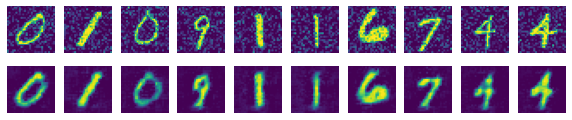

In [34]:
model.load_state_dict(torch.load(model_save_path2)["model_state_dict"])
reconstructed_images = model(images)
ROWS, COLS = 2, 10
recontructed_samples = []

for image in reconstructed_images:
  image = image.clamp(0,1)
  recontructed_samples.append(image.cpu().detach().numpy())
  if len(recontructed_samples) == ROWS*COLS:
    break

f, axs = plt.subplots(ROWS,COLS, figsize=(10,2))
a,b= 0,0

for i in range(ROWS):
  for j in range(COLS):
    if i == 1:
      im = recontructed_samples[a].reshape(28,28)
      a+=1
    else:
      im = add_noise(images[b].cpu().detach()).numpy().reshape(28,28) # add noise to original image
      b+=1
    axs[i,j].imshow(im)
    axs[i,j].axis('off')
print('Nosiy images and denoised images')

Summary: Applications such as image reconstruction, image encoding, image denoising, image coloring can be done by autoencoder. With more training auto-encoder might improve its results, still the results are pretty much good enough for a starter model. Improvements:
1. More Training.
2. Bigger network.
3. Better loss function.